In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

e:\Projects\Envs\Repo\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
e:\Projects\Envs\Repo\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


<h3>Load Data</h3>
<p>In the section, we will:</p>
<ul>
    <li>find the first few rows of data</li>
    <li>find data types</li>
    <li>test if there is any nulls</li>
</ul>

In [2]:
# data snapshot
bike_df = pd.read_csv("./data/bike.csv")
bike_df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [3]:
bike_df.describe()

,yr,temp,hum,windspeed,cnt,days_since_2011
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2011.500684,15.283085,62.789406,12.762576,4504.348837,365.000000
std,0.500342,8.603397,14.242910,5.192357,1937.211452,211.165812
min,2011.000000,-5.220871,0.000000,1.500244,22.000000,0.000000
25%,2011.000000,7.842925,52.000000,9.041650,3152.000000,182.500000
50%,2012.000000,15.421651,62.666700,12.125325,4548.000000,365.000000
75%,2012.000000,22.804575,73.020850,15.625371,5956.000000,547.500000
max,2012.000000,32.498349,97.250000,34.000021,8714.000000,730.000000


In [4]:
# check data type
bike_df.dtypes

season              object
yr                   int64
mnth                object
holiday             object
weekday             object
workingday          object
weathersit          object
temp               float64
hum                float64
windspeed          float64
cnt                  int64
days_since_2011      int64
dtype: object

In [5]:
# check data if there is any null values
bike_df.isnull().sum()

season             0
yr                 0
mnth               0
holiday            0
weekday            0
workingday         0
weathersit         0
temp               0
hum                0
windspeed          0
cnt                0
days_since_2011    0
dtype: int64

<h3>Data Feature Engineering</h3>
<p>in model explaining section, we will need to go through the same feature engineering process so that we have the exact dataset for prediction</p>

In [6]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# data cleaning
# converting yr to string / categorical variable
if bike_df.yr.dtype != pd.StringDtype:
    bike_df['yr'] = bike_df.yr.astype(str)
    print('convert yr to string')
else:
    print("yr is converted alredy")

convert yr to string


In [7]:
# prepare for one hot encoding and ordinal encoding
for item in ["season","yr","mnth","holiday","weekday","workingday","weathersit"]:
    print(f"{item}, {bike_df[item].unique()}")

season, ['WINTER' 'SPRING' 'SUMMER' 'FALL']
yr, ['2011' '2012']
mnth, ['JAN' 'FEB' 'MAR' 'APR' 'MAY' 'JUN' 'JUL' 'AUG' 'SEP' 'OCT' 'NOV' 'DEC']
holiday, ['NO HOLIDAY' 'HOLIDAY']
weekday, ['SAT' 'SUN' 'MON' 'TUE' 'WED' 'THU' 'FRI']
workingday, ['NO WORKING DAY' 'WORKING DAY']
weathersit, ['MISTY' 'GOOD' 'RAIN/SNOW/STORM']


In [8]:
# ordinal encoding
encode_map = {'season':['SPRING','SUMMER','FALL','WINTER']
    , 'yr':['2011','2012']
    , 'mnth':['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    , 'holiday':['NO HOLIDAY','HOLIDAY']
    , 'weekday':['MON','TUE','WED','THU','FRI','SAT','SUN']
    , 'workingday':['NO WORKING DAY','WORKING DAY']
    , 'weathersit':['MISTY','GOOD','RAIN/SNOW/STORM']
}

for k in encode_map.keys():
    bike_df[f'{k}_encoded'] = OrdinalEncoder(categories=[encode_map.get(k)])\
        .fit_transform(np.asarray(bike_df[k]).reshape(-1,1)).reshape(-1)

<h3>Exploratory Data Analysis</h3>
<p>In the section, we will:</p>
<ul>
    <li>find the correlation between resp "cnt" and the numerical features</li>
    <li>find the distribution of each numerical variable</li>
</ul>

In [9]:
# set up blueprint
cols_df = pd.DataFrame(bike_df.dtypes)
cols_df.reset_index(drop=False, inplace=True)
cols_df.rename(columns={"index":"cols",0:'data_types'}, inplace=True)
cols_df['input'] = cols_df.data_types.apply(lambda x: "cat" if x == 'object' else "num")
cols_df.loc[cols_df.cols == 'cnt', 'input'] = 'resp'

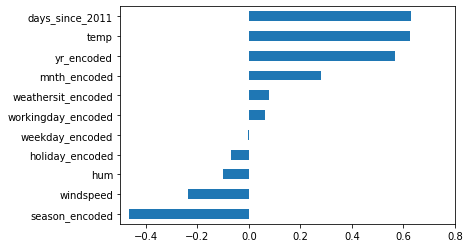

In [10]:
# EDA 
# calculate correlation
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
bike_df[cols_df.loc[cols_df.input.isin(['num']),'cols'].to_list()]\
    .corrwith(other = bike_df.cnt, axis=0, method='pearson').sort_values()\
    .plot(kind='barh', xlim=(-0.5,0.8))
plt.show()

array([[<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'hum'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'cnt'}>,
        <AxesSubplot:title={'center':'days_since_2011'}>,
        <AxesSubplot:title={'center':'season_encoded'}>],
       [<AxesSubplot:title={'center':'yr_encoded'}>,
        <AxesSubplot:title={'center':'mnth_encoded'}>,
        <AxesSubplot:title={'center':'holiday_encoded'}>],
       [<AxesSubplot:title={'center':'weekday_encoded'}>,
        <AxesSubplot:title={'center':'workingday_encoded'}>,
        <AxesSubplot:title={'center':'weathersit_encoded'}>]],
      dtype=object)

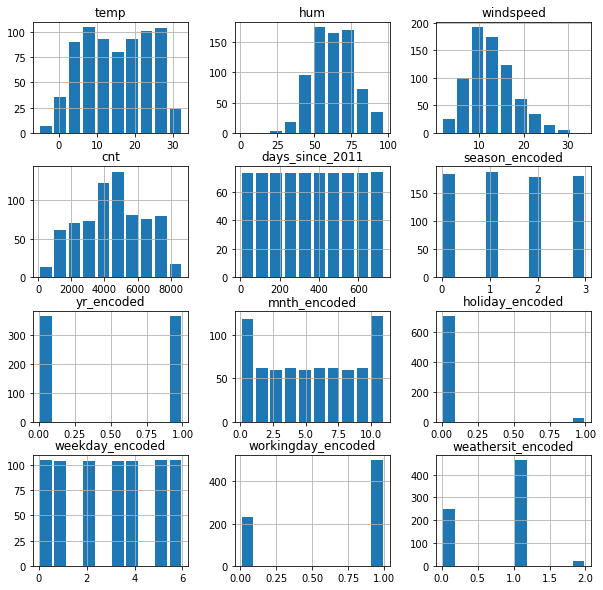

In [11]:
# ref: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.hist.html
bike_df[cols_df.loc[cols_df.input.isin(['num','resp']),'cols'].to_list()].hist(figsize=(10,10), rwidth=0.8)

indicating that tempeture is postively correlated to cnt, further validate the correlation plot from previous sectioin


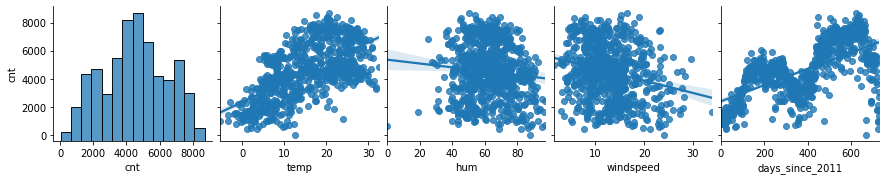

In [12]:
# inspired by https://www.kaggle.com/code/satyads/how-not-to-interpret-a-partial-dependence-plot?scriptVersionId=46333836
# seaborn ref: https://seaborn.pydata.org/generated/seaborn.PairGrid.html
# seaborn ref: https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot
# EDA on continous variables

x_vars = ['cnt', 'temp', 'hum','windspeed', 'days_since_2011']
y_vars = ['cnt']
cont_vars_df = bike_df[x_vars]
sns.pairplot(cont_vars_df, x_vars=x_vars, y_vars=y_vars, aspect=1, kind='reg')
print("indicating that tempeture is postively correlated to cnt, further validate the correlation plot from previous sectioin")

e:\Projects\Envs\Repo\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


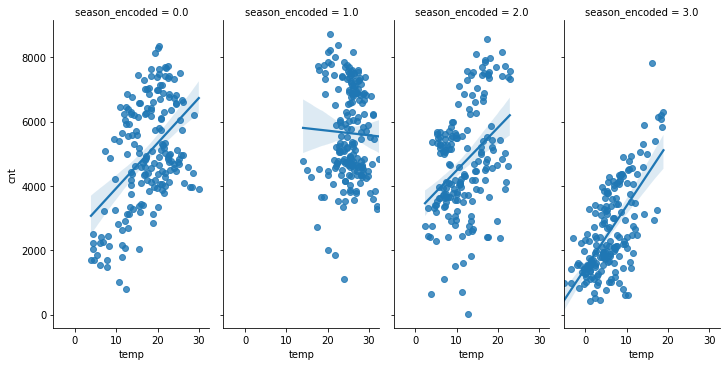

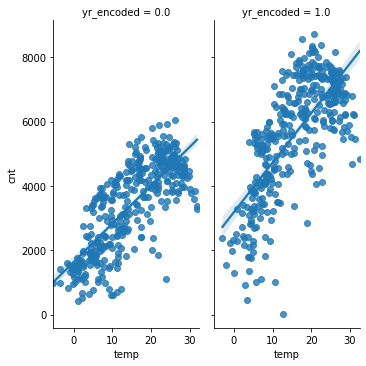

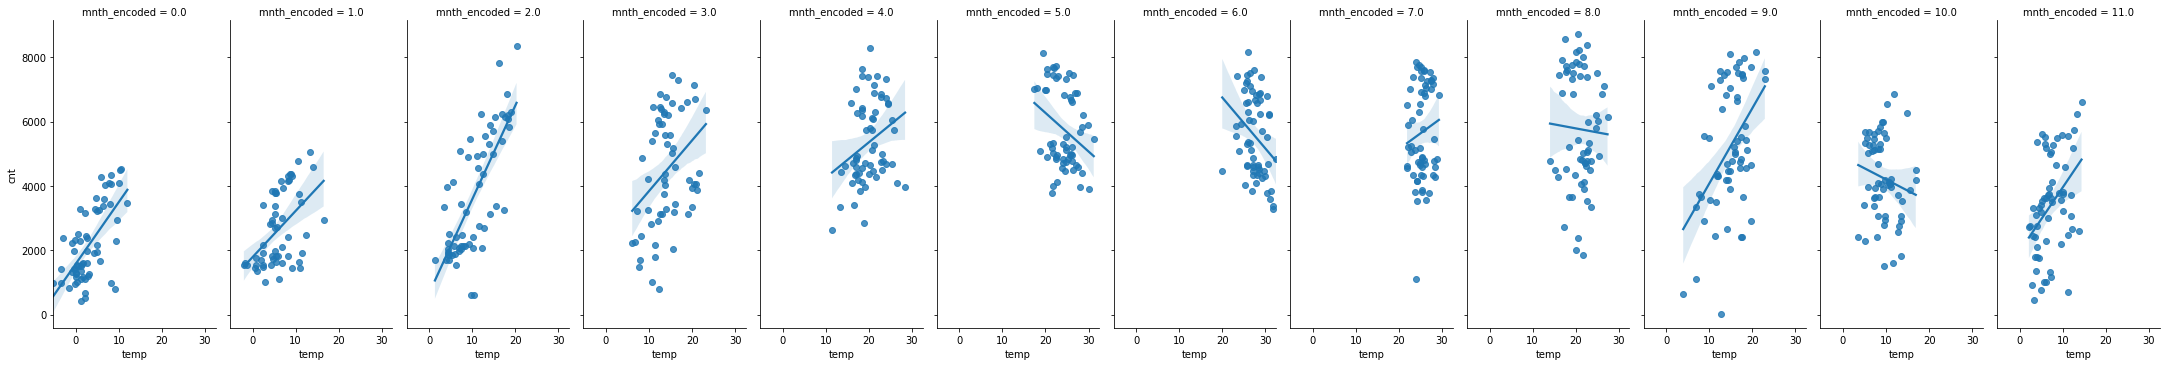

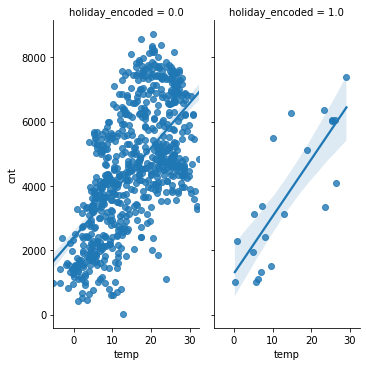

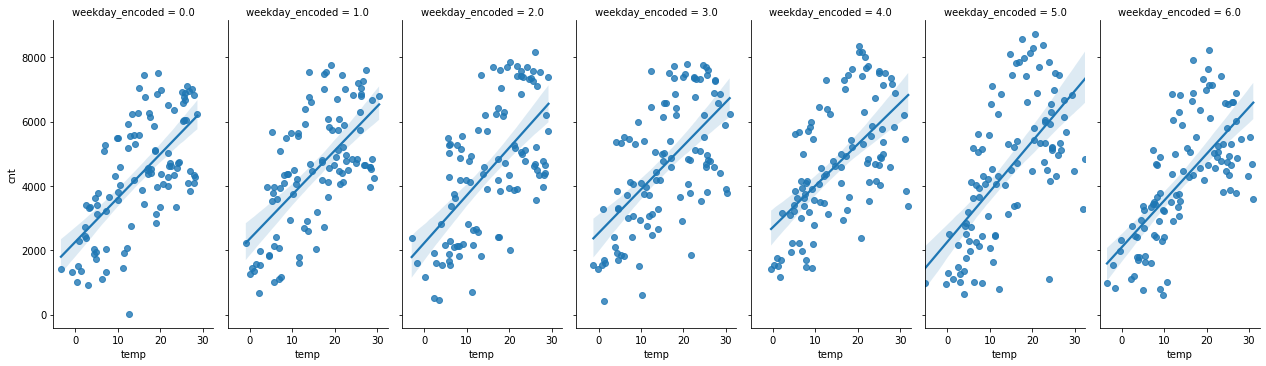

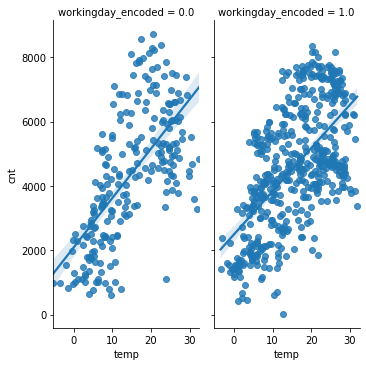

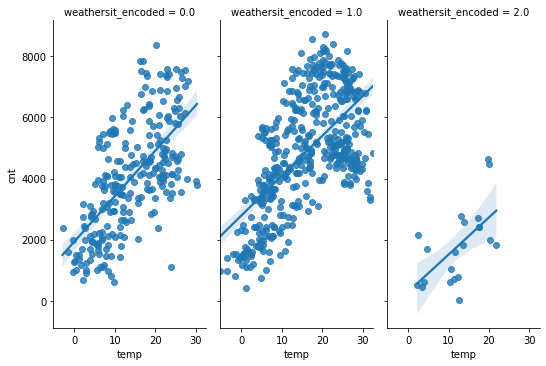

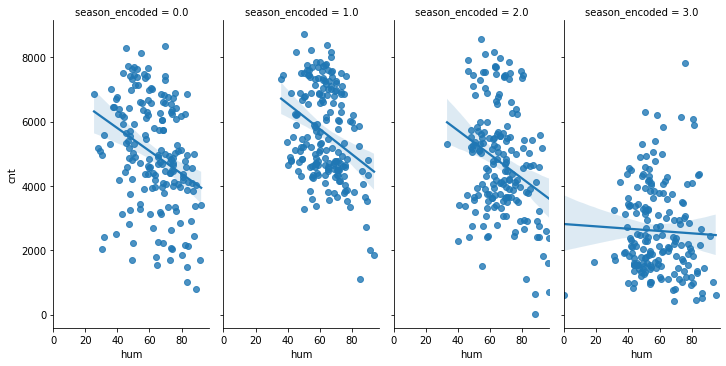

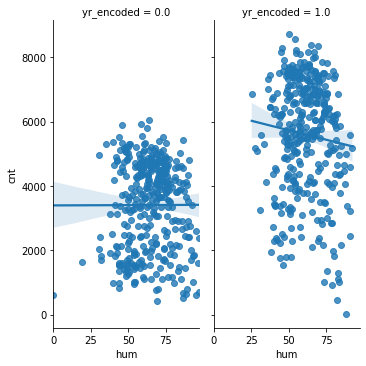

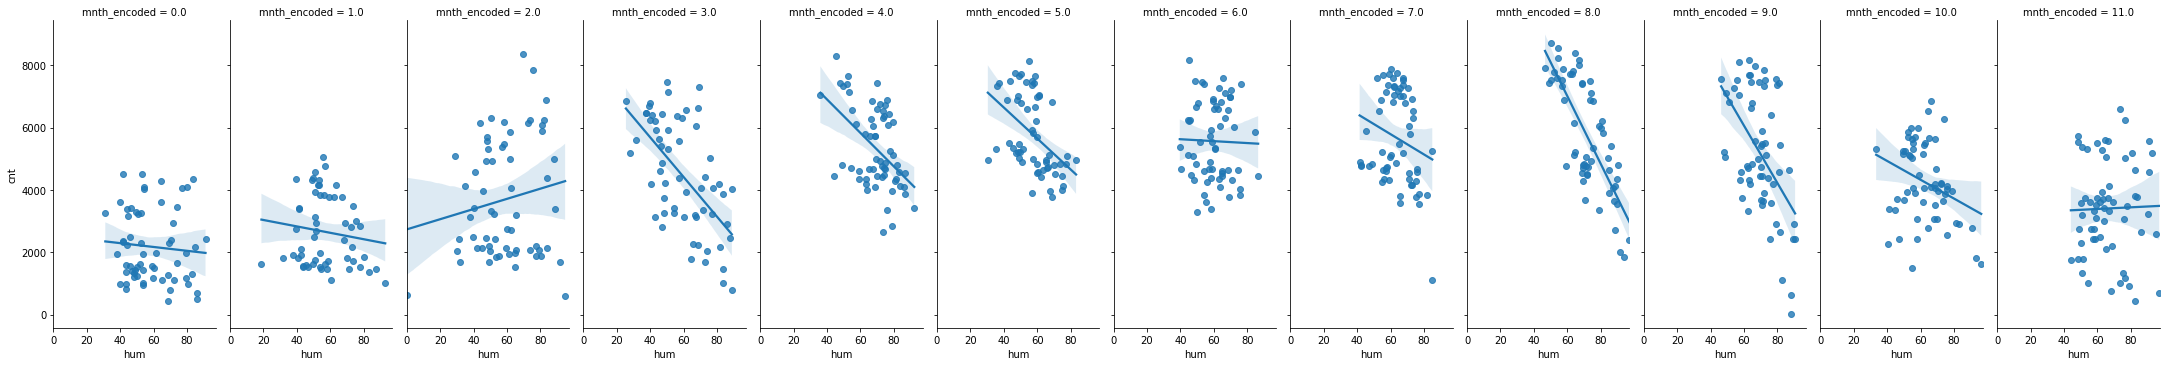

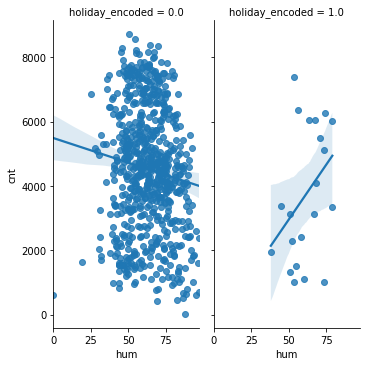

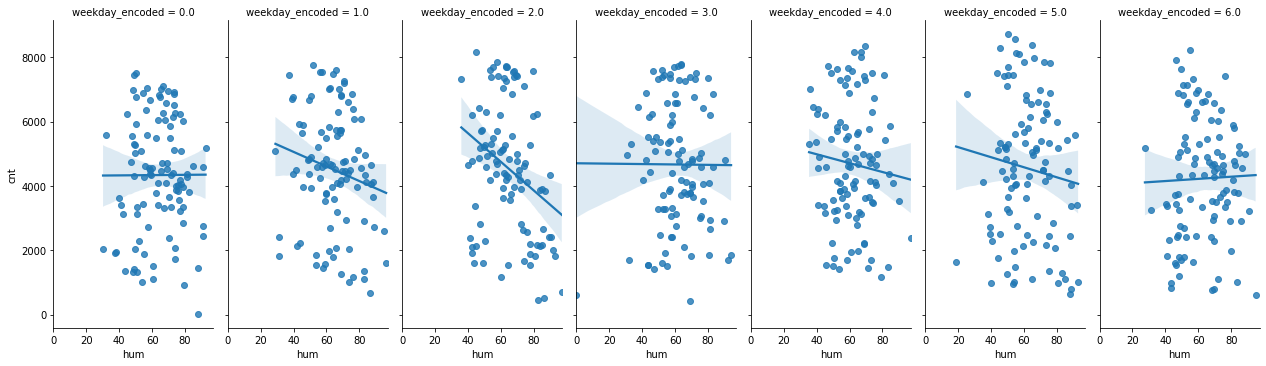

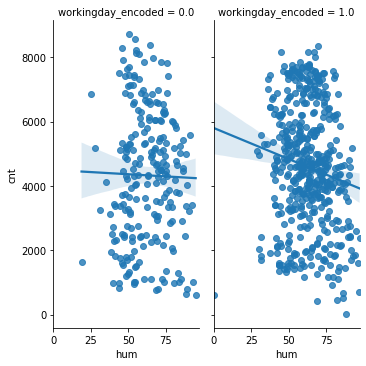

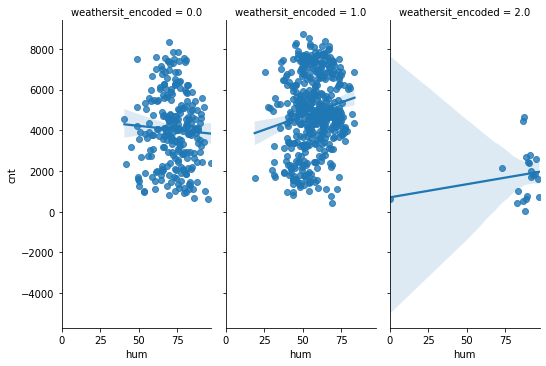

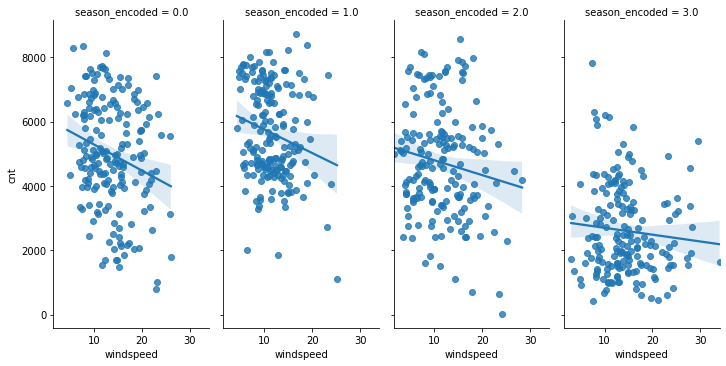

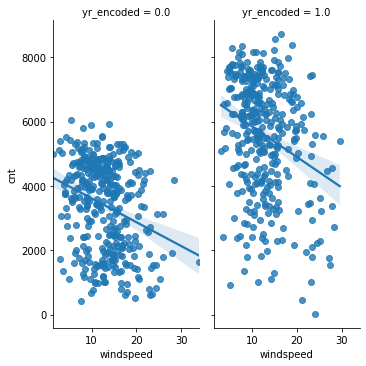

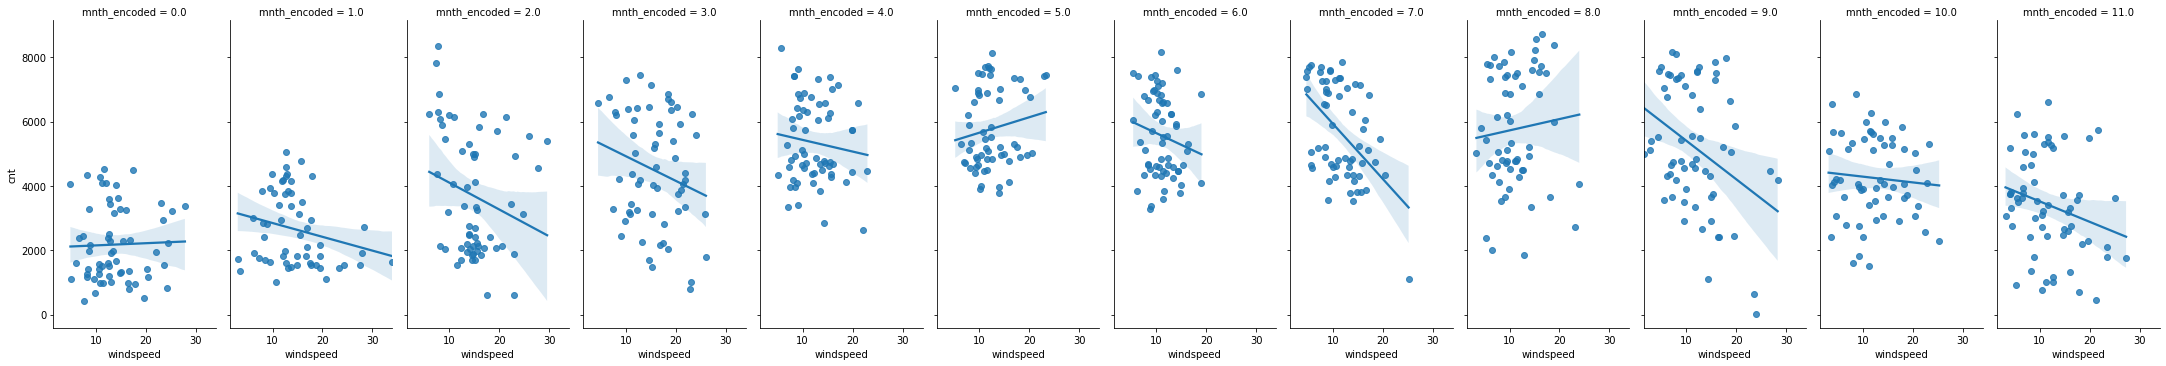

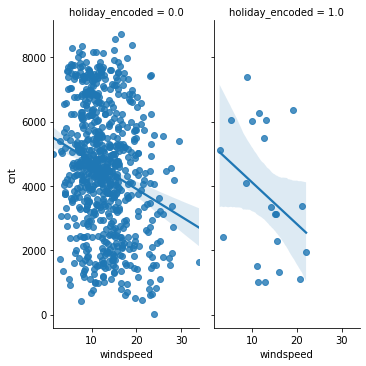

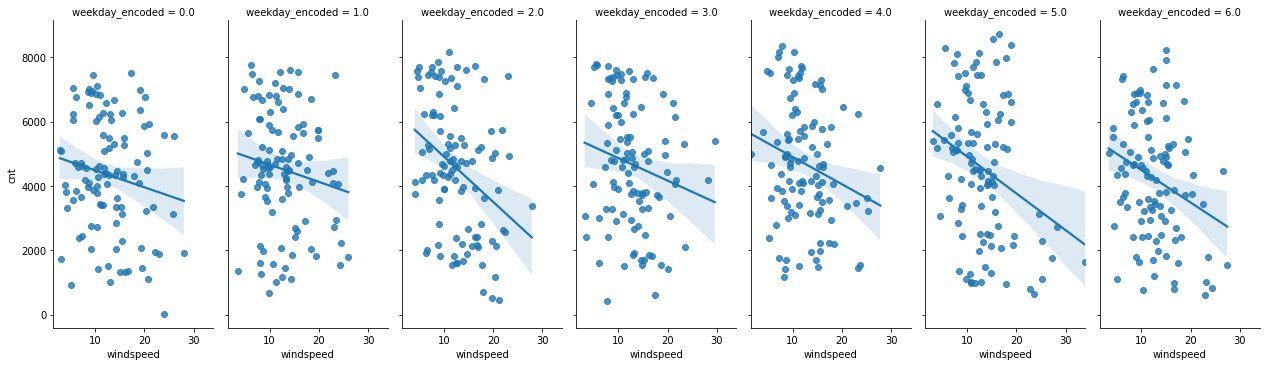

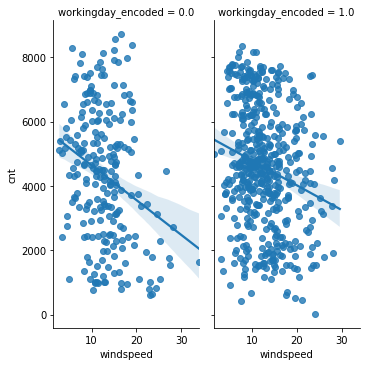

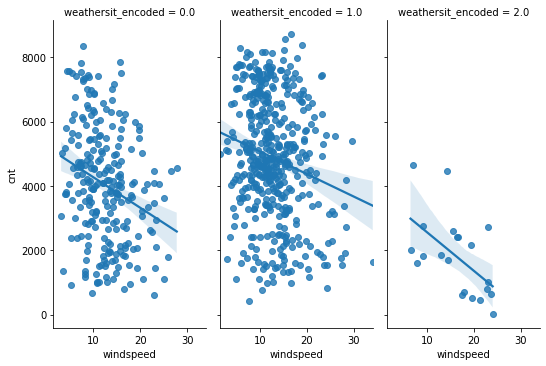

In [13]:
# seaborn ref: https://seaborn.pydata.org/generated/seaborn.lmplot.html
# EDA on categorical variables
for x in ['temp', 'hum','windspeed']:
    for c in ['season_encoded', 'yr_encoded','mnth_encoded','holiday_encoded','weekday_encoded','workingday_encoded', 'weathersit_encoded']:
        sns.lmplot(x = x, y='cnt',col=c, data=bike_df, aspect=0.5)

<h3>Modelling</h3>
<p>In the section, we will:</p>
<ul>
    <li>train LASSO model with L1 regularisation</li>
    <li>train a gradient boost tree</li>
</ul>

In [14]:
# reference
# GridSearchCV, https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import train_test_split, GridSearchCV  # used in training 
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.model_selection import ShuffleSplit, learning_curve    # used in plotting learning curve
from sklearn.metrics import mean_squared_error, make_scorer, r2_score


split_state = 801
feature_cols = cols_df.loc[cols_df.input.isin(['num']),'cols'].to_list()
X_train, X_test, y_train, y_test = train_test_split(bike_df[feature_cols].to_numpy(), bike_df['cnt'].to_numpy(), random_state=split_state, test_size=0.2)
print(f"""details of data:
holdout group size {len(X_test)}, {np.round(len(X_test)/len(bike_df),2) * 100}% 
and train/test group size {len(X_train)}, {np.round(len(X_train)/len(bike_df),2) * 100}%
""")

e:\Projects\Envs\Repo\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


details of data:
holdout group size 147, 20.0% 
and train/test group size 584, 80.0%



<h5>Train Lasso</h5>
<ul>
    <li>set up the parameter for fine tuning - L1 regularisation weight</li>
    <li>print out the stats</li>
</ul>


In [15]:
# train the model
lasso_params = {'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
grid_lasso_reg = GridSearchCV(Lasso(random_state=100, tol=1.2*1e-1, normalize=True, fit_intercept=True), lasso_params)
grid_lasso_reg.fit(X_train,y_train)
lasso_reg = grid_lasso_reg.best_estimator_

In [16]:
# print stats
lasso_reg_result = {'n_iter':lasso_reg.n_iter_,
"coefficient":lasso_reg.coef_,
"dual gap":lasso_reg.dual_gap_,
"intercept":lasso_reg.intercept_}
for k,v in lasso_reg_result.items():
    print(f"{k} - {v}")
lasso_reg.get_params()

n_iter - 3
coefficient - [ 1.07231159e+02 -2.58964027e+01 -5.79913661e+01  4.92419458e+00
 -2.81082198e+02  1.97739374e+02 -4.45294726e+01 -5.47255287e+02
 -1.46807948e-01  1.07815674e+02 -8.50389442e+01]
dual gap - 225541837.84918892
intercept - 3979.8336964987725


{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': 100,
 'selection': 'cyclic',
 'tol': 0.12,
 'warm_start': False}

<h5>Train Tree model</h5>
<ul>
    <li>set up the parameter for fine tuning - L1 regularisation weight</li>
    <li>print out the stats</li>
</ul>
<p>References</p>
<ul>
<li><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html">LightGBM Regressor Document</a></li>
<li><a href="https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html">LightGBM Parameter Tuning</a></li>
<li><a href='https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook'>Fine tuning LightGBM and dealing with Overfitting</a></li>
<li><a href="https://stackoverflow.com/questions/42011850/is-there-a-way-to-see-the-folds-for-cross-validation-in-gridsearchcv">How to find our test set for each grid search iteration and feed into lightgbm model to avoid over-fitting</a></li>
</ul>


In [21]:
# set up loss function
custom_scoring = make_scorer(mean_squared_error, greater_is_better=False)

# parameters to hypertune
gbt_params = {
    'max_depth':[3,6,9,12]
    , 'reg_alpha':[0.1,0.5,1,1.5]
    , 'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.6, 0.9]
    , 'num_leaves':[3,5,7]
}

# create the grid search on params
grid_gbt = GridSearchCV(
    estimator = LGBMRegressor(
        random_state=25
        , boosting_type='gbdt'
        , objective='regression'
        , verbose = -1
    ) # define our algorithm
    , param_grid = gbt_params  # define the metrics for searching
    , scoring = custom_scoring   # define the evaluation metrics
)

# approach 1 - lightgbm with internal validation set
grid_gbt.fit(X=X_train, y=y_train, feature_name = feature_cols)

# NOTE: approach 2
# lightgbm with validation set in training process
# [(shuffle_train, shuffle_test)] = list(
#     ShuffleSplit(n_splits=1,test_size=0.2, random_state=25).split(X_train)
#     )
# grid_gbt.fit(X=X_train[shuffle_train,:]
#     , y=y_train[shuffle_train]
#     , feature_name = feature_cols
#     # validation set for lightgbm
#     , eval_set=[(X_train[shuffle_test,:], y_train[shuffle_test])]
#     , eval_metric='rmse'
# )

# find best fit
gbt_reg = grid_gbt.best_estimator_

In [22]:
# export parameters
print('model parameters')
for k,v in gbt_reg.get_params().items():
    print(f"{k}:{v}")

# calculate errors
print(f"training set rsquare - {np.round(r2_score(y_train, gbt_reg.predict(X_train)),2)}")
print(f"testing set rsquare - {np.round(r2_score(y_test, gbt_reg.predict(X_test)),2)}")

model parameters
boosting_type:gbdt
class_weight:None
colsample_bytree:1.0
importance_type:split
learning_rate:0.3
max_depth:6
min_child_samples:20
min_child_weight:0.001
min_split_gain:0.0
n_estimators:100
n_jobs:-1
num_leaves:5
objective:regression
random_state:25
reg_alpha:0.5
reg_lambda:0.0
silent:True
subsample:1.0
subsample_for_bin:200000
subsample_freq:0
verbose:-1
training set rsquare - 0.96
testing set rsquare - 0.89


<h3>Model Evaluation</h3>
<p>In the section, we will:</p>
<ul>
    <li>Plotting Learning Curve</li>
    <li>Finding residues and ploting residue distribution. A true regression should have a normal distribution of residues. Our residue is close to a normal distribution, and indicates a good fit.</li>
    <li>A scatter plot between actual and predicted value. Along with Rsqured to calculate the improvement against random guess.</li>
</ul>

In [23]:
# plot learning curve
# reference of getting learning curve, https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
# np.linspace(start, stop, num=50), return evenly spaced numbers over a specified interval
# fill_between is to fill the area between two horizontal curves
def plot_learning_curve(estimator_name, estimator, X, y, ylim=None, cv=None, n_jobs=1,  scoring=None, train_sizes = np.linspace(.1, 1.0, 5)):
    f, ax = plt.subplots()
    if ylim is not None:
        plt.ylim(*ylim)
    # notes of learning_curve()
    # how to evaluate results?
    ### for regression, scorer is R^2
    ### for classification, scorer is accuracy
    # return from the function
    ### train_sizes_abs, array of shape, number of training examples that has been used to generate the learning curve
    ### train_scores, scores on training set
    ### test_scores, scores on test set
    if scoring is None:
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    else:
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    # It's calculating for each training size, the average score of the relevant cross-validation batch
    # for example, cv's n_splits is 100, and train_sizes is 46 (relatively 12 test examples). 
    # then we will see 100 scores,each is based on a random shuffle of total 58 examples, in which 46 training set and 12 test set. 
    train_scores_mean = np.mean(train_scores, axis=1)   
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html
    ax.fill_between(train_sizes, test_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",label="Cross-validation score")
    ax.set_title(f"{estimator_name} Learning Curve", fontsize=14)
    ax.set_xlabel('Training size')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'e:\\Projects\\Envs\\Repo\\lib\\site-packages\\matplotlib\\pyplot.py'>

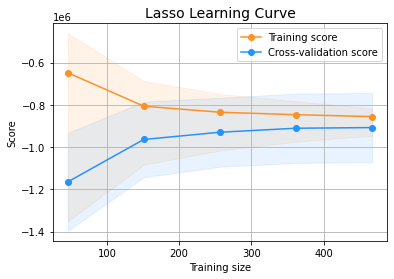

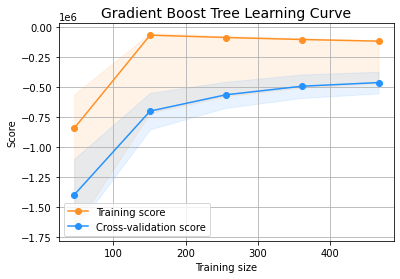

In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
# cv returns cross-validation generator, which is an generator of train_index and test_index
from sklearn.metrics import make_scorer, mean_squared_error
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
# how to use make scorer, https://scikit-learn.org/stable/modules/model_evaluation.html
plot_learning_curve("Lasso",lasso_reg, X_train, y_train, cv=cv, scoring=make_scorer(mean_squared_error, greater_is_better=False),n_jobs=1)

plot_learning_curve("Gradient Boost Tree", gbt_reg, X_train, y_train, cv=cv, scoring=make_scorer(mean_squared_error, greater_is_better=False),n_jobs=1)

e:\Projects\Envs\Repo\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


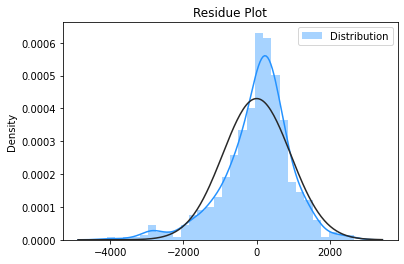

In [26]:
# plotting histogram plot
# specifically for linear regression models to test normality
#
from scipy.stats import norm
residues = y_train - lasso_reg.predict(X_train)
g = sns.distplot(residues, fit=norm, color='#2492ff', label='Distribution')
g.set_title("Residue Plot")
g.legend(loc='best')

plotting lasso


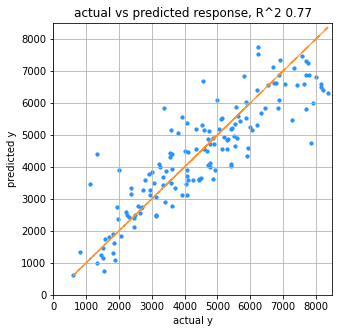

plotting gradient boost tree


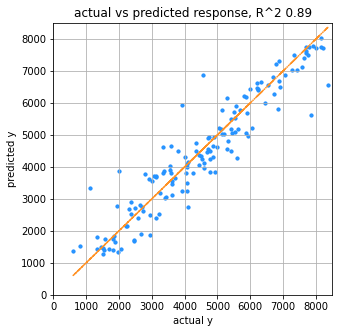

In [27]:
# plotting predicted and actual response
# reference: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.scatter.html
# reference of markers: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.markers.MarkerStyle.html#matplotlib.markers.MarkerStyle
from lib.ml_helper import plot_actual_and_pred
for k,v in {'lasso':lasso_reg,'gradient boost tree':gbt_reg}.items():
    print(f'plotting {k}')
    f = plot_actual_and_pred(v, np.vstack([X_test, X_test]), np.hstack([y_test,y_test]))
    f.show()

In [29]:
# export model
import pickle
filename = './model/bike_lasso.sav'
pickle.dump(lasso_reg, open(filename,'wb'))

filename = './model/bike_boost_tree.sav'
pickle.dump(gbt_reg, open(filename,'wb'))

# how to load model
# loaded_model = pickle.load(open(filename,'rb'))
# pred = loaded_model.score(X, y)
# print(pred)